In [1]:
import numpy as np
import pandas as pd
import os
import io
import zipfile
import sys
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing   import RobustScaler, MinMaxScaler
from PIL import Image

**UPLOAD THE DATA SUBSET**

In [2]:
from google.colab import files
uploaded = files.upload()

Saving raw-data-subset.zip to raw-data-subset (2).zip


**EXTRACT THE FILES FROM THE CSVs**

In [3]:
file_path = '/content/raw-data-subset.zip'


with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

main_zip_path = '/content/raw-data'
main_folder_files = os.listdir(main_zip_path)

for file in main_folder_files:
    if file.endswith('.zip'):
        inner_zip_file = os.path.join(main_zip_path, file)

        inner_extracted_folder = os.path.join(main_zip_path, file.replace('.zip', ''))
        os.makedirs(inner_extracted_folder, exist_ok=True)

        with zipfile.ZipFile(inner_zip_file, 'r') as inner_zip_ref:
            inner_zip_ref.extractall(inner_extracted_folder)

        print(f"Extracted: {inner_zip_file} -> {inner_extracted_folder}")

Extracted: /content/raw-data/order_products__train.csv.zip -> /content/raw-data/order_products__train.csv
Extracted: /content/raw-data/departments.csv.zip -> /content/raw-data/departments.csv
Extracted: /content/raw-data/products.csv.zip -> /content/raw-data/products.csv
Extracted: /content/raw-data/aisles.csv.zip -> /content/raw-data/aisles.csv
Extracted: /content/raw-data/orders.csv.zip -> /content/raw-data/orders.csv


**READ THE CSVs AND MAKE THE DATAFRAMES**

In [4]:
aisle_fp = '/content/raw-data/aisles.csv/aisles.csv'
department_fp = '/content/raw-data/departments.csv/departments.csv'
training_orders_fp = '/content/raw-data/order_products__train.csv/order_products__train.csv'
orders_fp = '/content/raw-data/orders.csv/orders.csv'
product_fp = '/content/raw-data/products.csv/products.csv'

# Read CSVs into DataFrames
aisles = pd.read_csv(aisle_fp)
departments = pd.read_csv(department_fp)
orders_training = pd.read_csv(training_orders_fp)
orders = pd.read_csv(orders_fp)
products = pd.read_csv(product_fp)

In [ ]:
print(aisles.head())
print(departments.head())
print(orders_training.head())
print(orders.head())
print(products.head())

**FIX NULL VALUES**

In [21]:
# We need to figure out what dataframes have null values
print("Products:")
print(products.isna().sum())
print()

print("Aisles:")
print(aisles.isna().sum())
print()

print("Departments:")
print(departments.isna().sum())
print()

print("Orders:")
print(orders.isna().sum())
print()

print("Training Orders:")
print(orders_training.isna().sum())
print()

Products:
product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

Aisles:
aisle_id    0
aisle       0
dtype: int64

Departments:
department_id    0
department       0
dtype: int64

Orders:
order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64

Training Orders:
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64



In [ ]:
# Orders has null values in 'days_since_prior_order'
orders['days_since_prior_order'] = orders['days_since_prior_order'].apply(lambda x: 0 if math.isnan( x ) else x )

**CHANGE ANY DATA TYPES**

In [ ]:
# Convert days_since_prior_order from float to int
orders['days_since_prior_order'] = orders['days_since_prior_order'].astype(int)

**SUMMARY OF DATA CLEANING CODE**

In [5]:
orders['days_since_prior_order'] = orders['days_since_prior_order'].apply(lambda x: 0 if math.isnan( x ) else x )
orders['days_since_prior_order'] = orders['days_since_prior_order'].astype(int)

**DATAFRAME OF ALL THE TABLES**

In [6]:
order_products = orders_training.merge(products, on ='product_id', how='left')
order_products = order_products.merge(aisles, on ='aisle_id', how='left')
order_products = order_products.merge(departments, on ='department_id', how='left')
order_products = order_products.merge(orders, on ='order_id', how='left')
order_products = order_products.dropna()

In [7]:
order_products

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs,112108,train,4,4,10,9
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs,112108,train,4,4,10,9
2,1,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce,112108,train,4,4,10,9
3,1,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce,112108,train,4,4,10,9
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods,112108,train,4,4,10,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384612,3421063,14233,3,1,Natural Artesian Water,115,7,water seltzer sparkling water,beverages,169679,train,30,0,10,4
1384613,3421063,35548,4,1,Twice Baked Potatoes,13,20,prepared meals,deli,169679,train,30,0,10,4
1384614,3421070,35951,1,1,Organic Unsweetened Almond Milk,91,16,soy lactosefree,dairy eggs,139822,train,15,6,10,8
1384615,3421070,16953,2,1,Creamy Peanut Butter,88,13,spreads,pantry,139822,train,15,6,10,8


**FEATURE ENGINEERING**

Adding new columns:

* Total number of products per user
* Total number of orders per user
* How many unique aisles the user buys from

Purpose: to better analyze user purchasing behavior

What we are looking for:

* Wealth


In [8]:
orders_df1 = order_products.copy()

# Total number of products per user
user_product_counts = orders_df1.groupby('user_id')['product_id'].count().reset_index() # Group by user_id and calculate the total number of products purchased
user_product_counts.rename(columns={'product_id': 'total_products'}, inplace=True)  # rename column
orders_df1 = orders_df1.merge(user_product_counts, on='user_id', how='left') # Merge the total product counts back to the order_products DataFrame

# How many unique aisles the user buys from
user_unique_aisle_counts = orders_df1.groupby('user_id')['aisle_id'].nunique().reset_index()
user_unique_aisle_counts.rename(columns={'aisle_id': 'distinct_aisles'}, inplace=True)
orders_df1 = orders_df1.merge(user_unique_aisle_counts, on='user_id', how='left')

In [9]:
orders_df1

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,total_products,distinct_aisles
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs,112108,train,4,4,10,9,8,6
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs,112108,train,4,4,10,9,8,6
2,1,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce,112108,train,4,4,10,9,8,6
3,1,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce,112108,train,4,4,10,9,8,6
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods,112108,train,4,4,10,9,8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384612,3421063,14233,3,1,Natural Artesian Water,115,7,water seltzer sparkling water,beverages,169679,train,30,0,10,4,4,4
1384613,3421063,35548,4,1,Twice Baked Potatoes,13,20,prepared meals,deli,169679,train,30,0,10,4,4,4
1384614,3421070,35951,1,1,Organic Unsweetened Almond Milk,91,16,soy lactosefree,dairy eggs,139822,train,15,6,10,8,3,3
1384615,3421070,16953,2,1,Creamy Peanut Butter,88,13,spreads,pantry,139822,train,15,6,10,8,3,3


**MERGING THE 2 FEATURE DERIVED ABOVE**

In [138]:
df_feat = pd.merge(user_product_counts, user_unique_aisle_counts, how='inner', on='user_id')
df_feat

,user_id,total_products,distinct_aisles
0,1,11,10
1,2,31,14
2,5,9,7
3,7,9,6
4,8,18,9
...,...,...,...
131204,206199,22,16
131205,206200,19,11
131206,206203,13,9
131207,206205,19,11


**FEATURE ENGINEERING STATS**

In [11]:
min_df = pd.DataFrame( df_feat.apply(lambda x: min(x), axis=0) ).T

max_df = pd.DataFrame( df_feat.apply(lambda x : max(x), axis=0) ).T

range_df = pd.DataFrame( df_feat.apply(lambda x : max(x) - min(x), axis=0 )).T

mean_df = pd.DataFrame( df_feat.apply(lambda x : np.mean(x), axis=0 )).T

median_df = pd.DataFrame( df_feat.apply(lambda x : np.median(x), axis=0 )).T

std_df = pd.DataFrame( df_feat.apply(lambda x : np.std(x), axis=0 )).T

skew_df = pd.DataFrame( df_feat.apply(lambda x : x.skew(), axis=0 )).T

kurtosis_df = pd.DataFrame( df_feat.apply(lambda x : x.kurtosis(), axis=0 )).T


attributes_table = pd.concat([min_df, max_df, range_df, mean_df, median_df, std_df, skew_df, kurtosis_df]).T.reset_index()
attributes_table.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
attributes_table

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,user_id,1.0,206209.0,206208.0,103166.825317,103150.0,59565.080817,-0.002343,-1.201587
1,total_products,1.0,80.0,79.0,10.552759,9.0,7.932817,1.480396,3.303779
2,distinct_aisles,1.0,44.0,43.0,7.551075,7.0,4.999626,1.134280,1.716275


**DISTRIBUTION OF FEATURES ADDED**

<Axes: title={'center': 'Distribution of distinct aisles bought from per user'}, xlabel='distinct_aisles', ylabel='Count'>

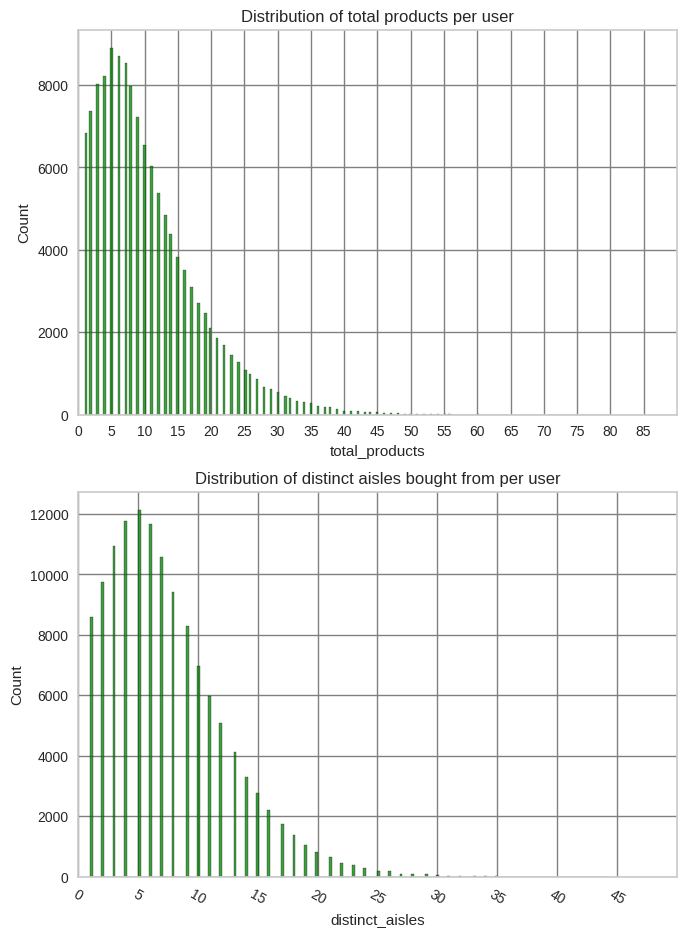

In [130]:
plt.figure(figsize=(17,11))
plt.subplot(2,2,1)
plt.title('Distribution of total products per user')
plt.xticks( np.arange(0, 90, 5), rotation=0 )
plt.xlim((0,90))
plt.grid(color='gray', linestyle='-', linewidth=1)
sns.histplot(df_feat['total_products'], color='green')


plt.subplot(2,2,3)
plt.title('Distribution of distinct aisles bought from per user')
plt.xticks( np.arange(0, 50, 5), rotation=-30 )
plt.xlim((0,50))
plt.grid(color='gray', linestyle='-', linewidth=1)
sns.histplot(df_feat['distinct_aisles'], color='green')

**FEATURE SCALING**

Feature scaling is often recommended when using distance-based clustering algorithms like K-means. Scaling ensures that all features contribute equally to the distance computations, preventing features with larger scales from dominating the clustering process.

MixMax scaling scales the feature into a specific range. Robust scaling is better for data with outliers.

In [139]:
df_feat2 = df_feat.copy()

<Axes: xlabel='total_products'>

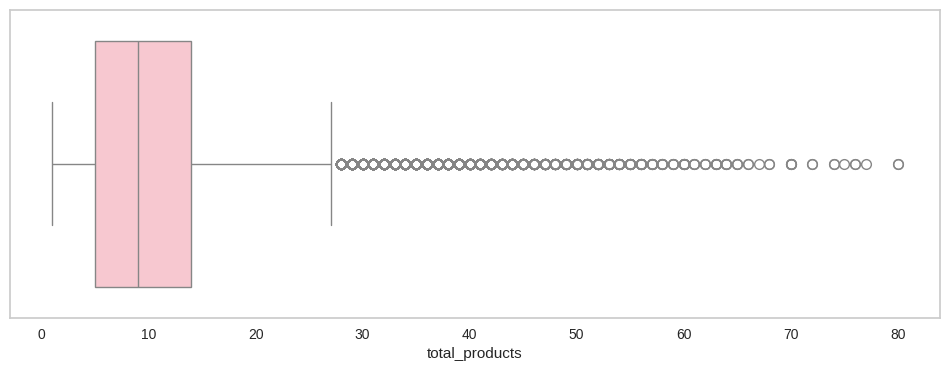

In [132]:
plt.figure(figsize=(12,4))
plt.grid(False)

sns.boxplot( data=df_feat2['total_products'], orient='h', color='pink')

There are some outliers, so we will use Robust scaling

<Axes: xlabel='distinct_aisles'>

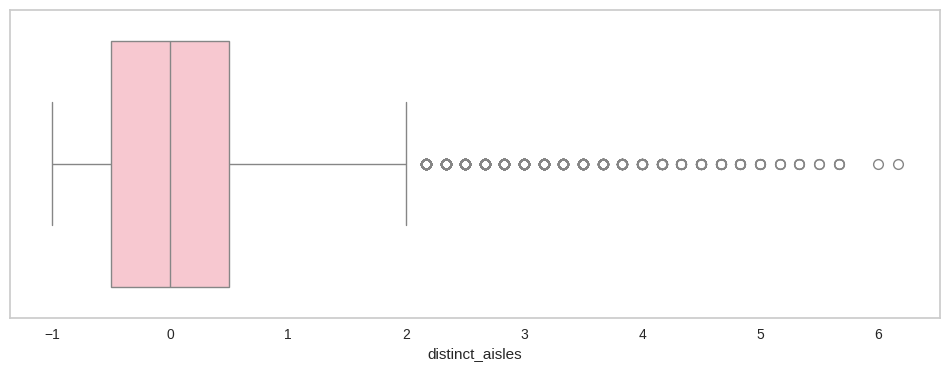

In [133]:
rs = RobustScaler()
df_feat2['distinct_aisles'] = rs.fit_transform( df_feat2[['distinct_aisles']].values )

plt.figure(figsize=(12,4))
plt.grid(False)

sns.boxplot( data=df_feat2['distinct_aisles'], orient='h', color='pink')

<Axes: xlabel='total_products'>

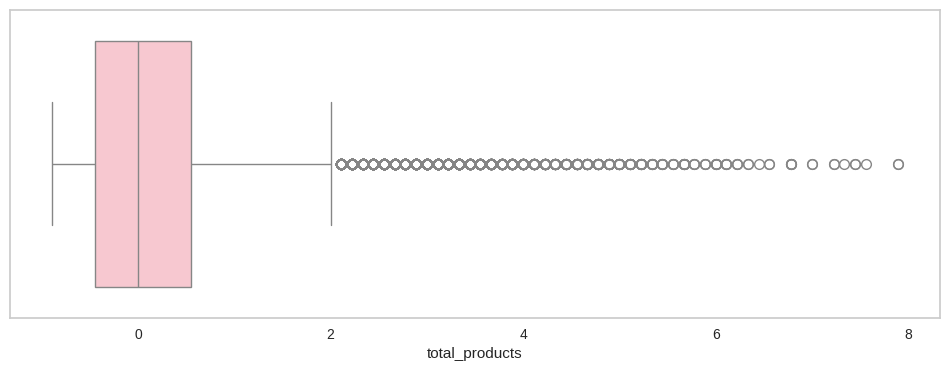

In [134]:
rs = RobustScaler()
df_feat2['total_products'] = rs.fit_transform( df_feat2[['total_products']].values )

plt.figure(figsize=(12,4))
plt.grid(False)

sns.boxplot( data=df_feat2['total_products'], orient='h', color='pink')

In [140]:
df_feat2['total_products'] = np.where(df_feat2['total_products'] == 0, 1e-9, df_feat2['total_products'])
df_feat2['distinct_aisles'] = np.where(df_feat2['distinct_aisles'] == 0, 1e-9, df_feat2['distinct_aisles'])

df_feat2['total_products'] = np.log1p( df_feat2['total_products'] )
df_feat2['distinct_aisles'] = np.log1p( df_feat2['distinct_aisles'] )

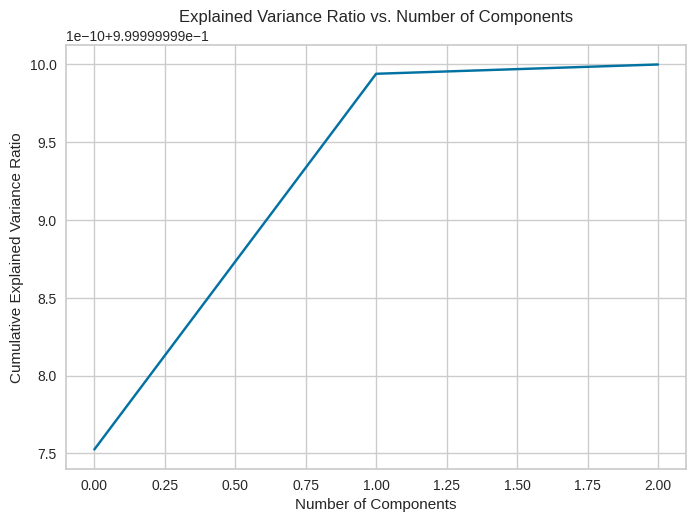

In [141]:
pca2 = PCA()


pca2.fit(df_feat2)


# Plot explained variance ratio
plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.show()

In [151]:
from sklearn.decomposition import PCA

pca2 = PCA(n_components=1)
pca_df2 = pca2.fit_transform(df_feat2[['total_products', 'distinct_aisles']])
pca_df2 = pd.DataFrame(pca_df2)
display(pca_df2)

,0
0,0.483036
1,1.429277
2,0.137267
3,0.050289
4,0.769630
...,...
131204,1.260229
131205,0.927307
131206,0.537918
131207,0.927307


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

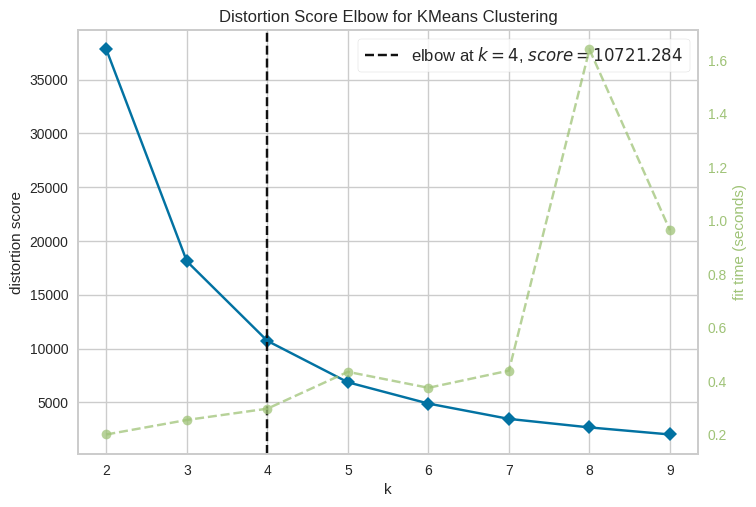

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [152]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

kmeans = KMeans()
elbow_chart = KElbowVisualizer(kmeans, k=(2, 10))
elbow_chart.fit(pca_df2)
elbow_chart.show()

In [153]:
kmeans2 = KMeans(n_clusters=4, random_state=42)
cluster_labels2 = kmeans2.fit_predict(pca_df2)
df_feat['cluster'] = cluster_labels2

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [154]:
num_clusters2 = df_feat['cluster'].nunique()
cluster_results2 = []

# Iterate through each cluster
for cluster_num in range(num_clusters2):
    cluster_data = df_feat[df_feat['cluster'] == cluster_num]
    cluster_mean = cluster_data.drop('cluster', axis=1).mean().sort_values(ascending=False)[0:20]
    cluster_results2.append((f"Cluster {cluster_num}", cluster_mean))

# Display all results in separate tables
for result in cluster_results2:
    cluster_name, cluster_mean = result
    print(f"Cluster {cluster_name}")
    display(pd.DataFrame(cluster_mean, columns=['Mean']).reset_index().rename(columns={'index': 'Feature'}))
    print("\n")

Cluster Cluster 0


,Feature,Mean
0,user_id,103718.399408
1,total_products,5.256775
2,distinct_aisles,4.202951




Cluster Cluster 1


,Feature,Mean
0,user_id,102821.172718
1,total_products,11.039683
2,distinct_aisles,8.153861




Cluster Cluster 2


,Feature,Mean
0,user_id,102930.896185
1,total_products,1.758820
2,distinct_aisles,1.494717




Cluster Cluster 3


,Feature,Mean
0,user_id,103086.767628
1,total_products,22.577172
2,distinct_aisles,14.964103


In [156]:
cluster_user_ids2 = df_feat2.groupby('cluster')['user_id'].unique()

# Print user IDs for each cluster
for cluster_label, user_ids in cluster_user_ids2.items():
    print(f"Cluster {cluster_label} User IDs: {user_ids}")

Cluster 0 User IDs: [155325 155326 155328 ... 206203 206205 206209]
Cluster 1 User IDs: [ 51835  51836  51838 ... 103816 103817 103819]
Cluster 2 User IDs: [103821 103823 103824 ... 155319 155320 155322]
Cluster 3 User IDs: [    1     2     5 ... 51831 51832 51833]


**NEW CLUSTERING BELOW**
.

.

---



**CLUSTERS BASED ON PRODUCTS**



In [93]:
cross_order_product = pd.crosstab(order_products.user_id, order_products.aisle)
cross_order_product.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0


In [98]:
normalize_df = cross_order_product.div(cross_order_product.sum(axis=1), axis=0)
normalize_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.090909
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
5,0.111111,0.222222,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
7,0.000000,0.000000,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
8,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.055556,0.055556,0.0,0.0,0.0,0.0,0.0,0.000000


In [99]:
normalized2 = normalize_df.drop('fresh fruits', axis=1)
normalized2 = normalized2.drop('fresh vegetables', axis=1)
normalized2 = normalized2.drop('yogurt', axis=1)
normalized2 = normalized2.drop('packaged vegetables fruits', axis=1)
normalized2 = normalized2.drop('milk', axis=1)


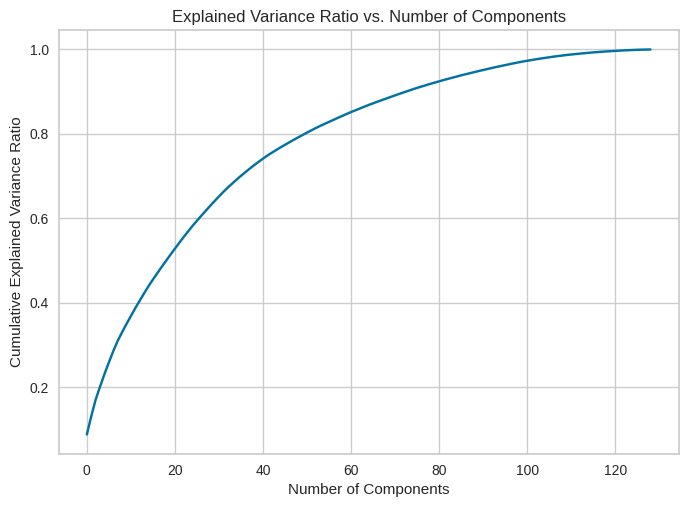

In [100]:
import numpy as np
import matplotlib.pyplot as plt

# Fit PCA with a range of components
pca = PCA()
pca.fit(normalized2)

# Plot explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.show()

In [101]:
from sklearn.decomposition import PCA

pca = PCA(n_components=80)
pca_df = pca.fit_transform(normalized2)
pca_df = pd.DataFrame(pca_df)
display(pca_df)

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,-0.031708,-0.037369,0.161334,-0.054364,0.047132,-0.021932,-0.005052,-0.014167,0.076735,-0.004664,...,-0.000432,-0.003358,0.003173,-0.000870,0.003053,-0.000581,-0.000508,0.000915,-0.001147,-0.000010
1,-0.041442,-0.024738,-0.015305,0.084749,0.015536,0.008959,-0.022779,-0.009584,-0.050169,0.206697,...,0.022137,-0.010758,0.004495,-0.003147,-0.004008,0.003101,-0.005327,0.001384,-0.005884,0.004053
2,-0.037999,-0.012268,-0.021795,-0.054886,0.065575,-0.021641,0.008315,-0.002281,0.003587,-0.004732,...,0.001157,0.000609,-0.010121,-0.000054,0.009513,-0.004715,-0.000276,-0.012040,-0.012587,-0.000255
3,-0.041700,-0.038244,-0.033785,0.029766,-0.197296,-0.103470,0.346501,0.126233,0.024358,-0.004607,...,-0.001700,0.003124,0.002749,0.003647,-0.005565,-0.016235,0.001892,0.001715,-0.007148,-0.001784
4,-0.035182,-0.009309,-0.016947,-0.004912,-0.031418,-0.023628,-0.036270,0.018864,-0.002946,-0.008943,...,-0.000327,0.003857,0.003787,-0.031857,-0.005195,0.005079,-0.019660,0.003477,0.015016,-0.006713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131204,0.005079,-0.025296,0.025802,-0.025288,0.017567,0.051222,-0.003022,-0.015464,-0.028453,0.032188,...,-0.000608,0.000337,0.005100,-0.010952,0.014315,-0.019065,0.031891,0.000451,0.003153,-0.000933
131205,0.067368,-0.015137,-0.020696,0.088269,0.017054,-0.031218,-0.030928,0.025604,-0.005118,-0.017215,...,-0.000223,0.000743,-0.000247,-0.000631,0.001325,-0.000161,-0.001511,0.001163,-0.003549,0.000458
131206,-0.037600,-0.025034,-0.019765,0.007504,-0.081624,-0.026644,0.025192,0.033576,-0.023091,0.062620,...,-0.000256,0.000889,0.001793,-0.001364,-0.000237,-0.002259,-0.000766,0.000058,-0.000324,-0.000247
131207,-0.036953,-0.009508,-0.018472,-0.029684,0.022308,-0.012797,-0.007730,-0.013579,-0.016874,-0.014239,...,0.000481,0.004189,-0.002243,-0.000536,0.006064,-0.001522,-0.007861,0.002679,-0.011318,0.000592


**ELBOW METHOD TO FIND OPTIMAL NUMBER OF CLUSTERS**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

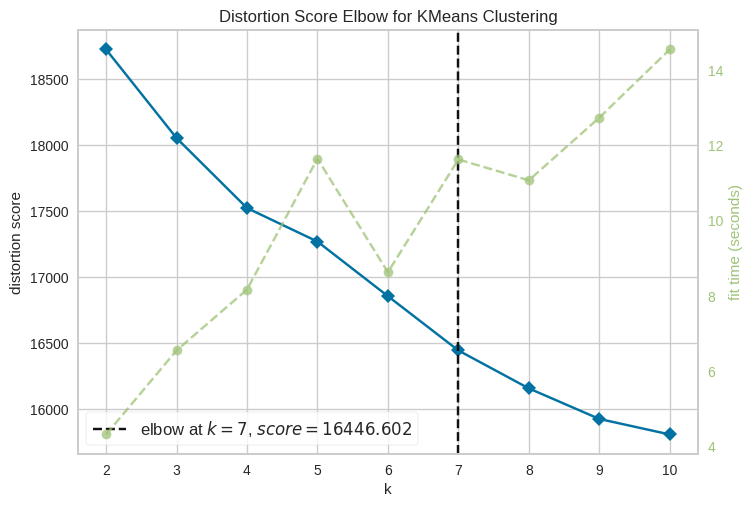

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [103]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

kmeans = KMeans()
elbow_chart = KElbowVisualizer(kmeans, k=(10))
elbow_chart.fit(pca_df)
elbow_chart.show()

**K-MEANS CLUSTERING**

In [105]:
cross_op2 = cross_order_product.drop('fresh fruits', axis=1)
cross_op2 = cross_op2.drop('fresh vegetables', axis=1)
cross_op2 = cross_op2.drop('yogurt', axis=1)
cross_op2 = cross_op2.drop('packaged vegetables fruits', axis=1)
cross_op2 = cross_op2.drop('milk', axis=1)
cross_op2.reset_index(inplace=True)
cross_op2

aisle,user_id,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,...,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131204,206199,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
131205,206200,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2,0
131206,206203,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,0
131207,206205,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
kmeans = KMeans(n_clusters=7, random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cross_op2['cluster'] = cluster_labels

In [106]:
# See cluster 1
cluster1 = cross_op2[cross_op2.cluster == 1]
cluster1_mean = cluster1.drop('cluster', axis=1).mean().sort_values(ascending=False)[0:20]
print(cluster1.shape)
cluster1.drop('cluster', axis=1).mean().sort_values(ascending=False)[0:20]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(97917, 131)


aisle
user_id                          103108.634517
water seltzer sparkling water         0.253041
soy lactosefree                       0.230450
refrigerated                          0.200650
frozen produce                        0.199914
bread                                 0.193072
packaged cheese                       0.173586
eggs                                  0.169654
frozen meals                          0.158553
chips pretzels                        0.155070
crackers                              0.153405
energy granola bars                   0.149800
fresh herbs                           0.143877
ice cream ice                         0.142478
cereal                                0.136902
soup broth bouillon                   0.133286
lunch meat                            0.127537
baby food formula                     0.123002
juice nectars                         0.121225
fresh dips tapenades                  0.115772
dtype: float64

In [108]:
cluster_user_ids = cross_op2.groupby('cluster')['user_id'].unique()

# Print user IDs for each cluster
for cluster_label, user_ids in cluster_user_ids.items():
    print(f"Cluster {cluster_label} User IDs: {user_ids}")

Cluster 0 User IDs: [    78    374    387 ... 206031 206042 206156]
Cluster 1 User IDs: [     1      2      7 ... 206203 206205 206209]
Cluster 2 User IDs: [    30    271    345 ... 206133 206136 206159]
Cluster 3 User IDs: [     5     38     63 ... 206171 206177 206190]
Cluster 4 User IDs: [    46     82     84 ... 206110 206121 206162]
Cluster 5 User IDs: [    67     81    105 ... 205968 205974 206039]
Cluster 6 User IDs: [    49    117    171 ... 206033 206097 206118]


# Get results for all 7 clusters

In [107]:
num_clusters = cross_op2['cluster'].nunique()
cluster_results = []

# Iterate through each cluster
for cluster_num in range(num_clusters):
    cluster_data = cross_op2[cross_op2['cluster'] == cluster_num]
    cluster_mean = cluster_data.drop('cluster', axis=1).mean().sort_values(ascending=False)[0:20]
    cluster_results.append((f"Cluster {cluster_num}", cluster_mean))

# Display all results in separate tables
for result in cluster_results:
    cluster_name, cluster_mean = result
    print(f"Cluster {cluster_name}")
    display(pd.DataFrame(cluster_mean, columns=['Mean']).reset_index().rename(columns={'index': 'Feature'}))
    print("\n")

Cluster Cluster 0


,aisle,Mean
0,user_id,103049.566848
1,soft drinks,1.664130
2,water seltzer sparkling water,0.252174
3,candy chocolate,0.058696
4,juice nectars,0.051087
5,chips pretzels,0.049457
6,paper goods,0.048370
7,refrigerated,0.044022
8,cream,0.044022
9,energy sports drinks,0.041304




Cluster Cluster 1


,aisle,Mean
0,user_id,103108.634517
1,water seltzer sparkling water,0.253041
2,soy lactosefree,0.230450
3,refrigerated,0.200650
4,frozen produce,0.199914
5,bread,0.193072
6,packaged cheese,0.173586
7,eggs,0.169654
8,frozen meals,0.158553
9,chips pretzels,0.155070




Cluster Cluster 2


,aisle,Mean
0,user_id,104049.395966
1,water seltzer sparkling water,2.060156
2,soft drinks,0.093418
3,paper goods,0.044586
4,soy lactosefree,0.042463
5,chips pretzels,0.038924
6,refrigerated,0.037863
7,juice nectars,0.037509
8,tea,0.037509
9,coffee,0.036801




Cluster Cluster 3


,aisle,Mean
0,user_id,102792.293206
1,packaged cheese,1.538780
2,lunch meat,0.231812
3,bread,0.216514
4,chips pretzels,0.198811
5,water seltzer sparkling water,0.188723
6,crackers,0.176164
7,eggs,0.163738
8,other creams cheeses,0.150043
9,soy lactosefree,0.144432




Cluster Cluster 4


,aisle,Mean
0,user_id,103723.460969
1,chips pretzels,1.674697
2,water seltzer sparkling water,0.262853
3,fresh dips tapenades,0.239031
4,crackers,0.210229
5,energy granola bars,0.170256
6,soft drinks,0.164738
7,candy chocolate,0.151952
8,cookies cakes,0.150336
9,refrigerated,0.147376




Cluster Cluster 5


,aisle,Mean
0,user_id,104001.485140
1,packaged produce,1.847276
2,water seltzer sparkling water,0.112823
3,packaged cheese,0.075674
4,frozen produce,0.066318
5,chips pretzels,0.053110
6,oils vinegars,0.052559
7,nuts seeds dried fruit,0.050358
8,bread,0.048431
9,frozen meat seafood,0.044029




Cluster Cluster 6


,aisle,Mean
0,user_id,103882.943309
1,ice cream ice,2.128808
2,water seltzer sparkling water,0.141149
3,soft drinks,0.111068
4,chips pretzels,0.104898
5,refrigerated,0.097956
6,soy lactosefree,0.097570
7,packaged cheese,0.080602
8,missing,0.075974
9,candy chocolate,0.074431


**SUMMARY DATA**

[Reference](https://github.com/gabrielhpr/InstacartClustering/blob/master/InstacartClustering.ipynb)

In [ ]:
num_data = order_products.select_dtypes( include=['int64'] )
cat_data = order_products.select_dtypes( exclude=['int64'] )


min_df = pd.DataFrame( num_data.apply(lambda x: min(x), axis=0) ).T
min_df['days_since_prior_order'] = min( num_data[ num_data['days_since_prior_order'] != -1 ]['days_since_prior_order'] )

max_df = pd.DataFrame( num_data.apply(lambda x : max(x), axis=0) ).T

range_df = pd.DataFrame( num_data.apply(lambda x : max(x) - min(x), axis=0 )).T

mean_df = pd.DataFrame( num_data.apply(lambda x : np.mean(x), axis=0 )).T

median_df = pd.DataFrame( num_data.apply(lambda x : np.median(x), axis=0 )).T

std_df = pd.DataFrame( num_data.apply(lambda x : np.std(x), axis=0 )).T

skew_df = pd.DataFrame( num_data.apply(lambda x : x.skew(), axis=0 )).T

kurtosis_df = pd.DataFrame( num_data.apply(lambda x : x.kurtosis(), axis=0 )).T


attributes_table = pd.concat([min_df, max_df, range_df, mean_df, median_df, std_df, skew_df, kurtosis_df]).T.reset_index()
attributes_table.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
attributes_table

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,order_id,1.0,3421070.0,3421069.0,1.706298e+06,1701880.0,989732.291465,0.006332,-1.206626
1,product_id,1.0,49688.0,49687.0,2.555624e+04,25298.0,14121.267349,-0.022355,-1.153794
2,add_to_cart_order,1.0,80.0,79.0,8.758044e+00,7.0,7.423934,1.685549,4.172226
3,reordered,0.0,1.0,1.0,5.985944e-01,1.0,0.490183,-0.402277,-1.838176
4,aisle_id,1.0,134.0,133.0,7.130423e+01,83.0,38.104081,-0.171007,-1.315048
5,department_id,1.0,21.0,20.0,9.839777e+00,8.0,6.292828,0.178673,-1.537293
6,user_id,1.0,206209.0,206208.0,1.031128e+05,102933.0,59487.126406,-0.000327,-1.200721
7,order_number,4.0,100.0,96.0,1.709141e+01,11.0,16.614031,2.243372,5.896714
8,order_dow,0.0,6.0,6.0,2.701392e+00,3.0,2.167645,0.175516,-1.398946
9,order_hour_of_day,0.0,23.0,23.0,1.357759e+01,14.0,4.238456,-0.121030,0.043846


**Comparing clusters**

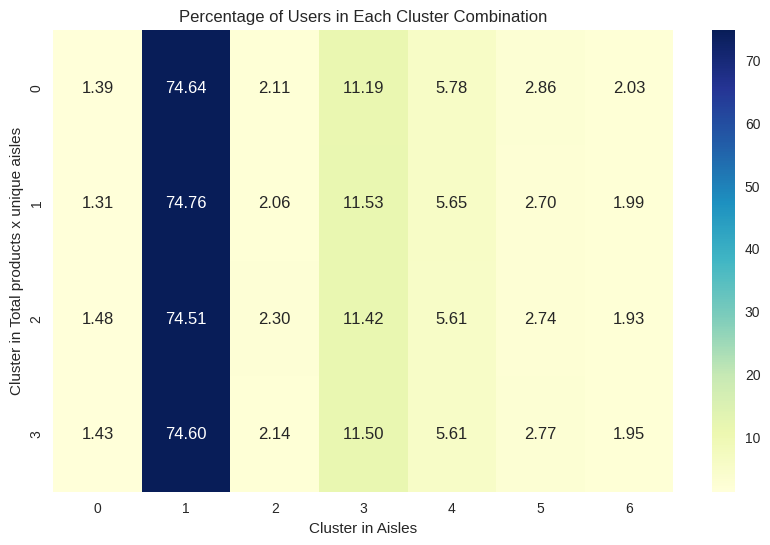

In [159]:
cross_op3 = cross_op2.copy()
cross_op3.rename(columns={'cluster': 'cluster_cross_op'}, inplace=True)

combined_df = pd.merge(df_feat2, cross_op3, on='user_id', how='inner')

# Group by cluster labels from both DataFrames
grouped = combined_df.groupby(['cluster', 'cluster_cross_op']).size().reset_index(name='count')

# Calculate the total count of users in each cluster from df_feat2
total_users_df_feat2 = df_feat2.groupby('cluster').size()

# Calculate the percentage of users in each combination relative to the total number of users in the corresponding cluster from df_feat2
grouped['percentage'] = grouped.apply(lambda row: (row['count'] / total_users_df_feat2[row['cluster']]) * 100, axis=1)


heatmap_data = grouped.pivot(index='cluster', columns='cluster_cross_op', values='percentage')
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".2f", cbar=True)
plt.title('Percentage of Users in Each Cluster Combination')
plt.xlabel('Cluster in Aisles')
plt.ylabel('Cluster in Total products x unique aisles')
plt.show()

In [158]:
grouped

,cluster,cluster_cross_op,count,percentage
0,0,0,451,1.387607
1,0,1,24259,74.638484
2,0,2,685,2.107563
3,0,3,3636,11.187004
4,0,4,1880,5.784259
5,0,5,931,2.864439
6,0,6,660,2.030644
7,1,0,434,1.312249
8,1,1,24726,74.761890
9,1,2,681,2.059081
